<a href="https://colab.research.google.com/github/Yordi23/Machine_Learning/blob/master/Churn_Analysis_Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn.metrics as metr
import seaborn as sns

In [12]:
#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LassoCV
#from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
#from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
#from keras.callbacks import EarlyStopping

In [13]:
path = '/content/drive/My Drive/Colab Notebooks/Resources/Clientes_Internet._churn_A.csv'
clients_churn = pd.read_csv(path, encoding='latin-1')

In [14]:
clients_churn

,SubscriptionId,Edad,Sexo,CityId,CityName,ProvinceId,ProvinceName,TipoFacturacion,SubscripcionFechaCreacion,SubscripcionFechaActivacion,SubscripcionFechaDesconexion,CantEstadoSuspendidoParcial,CantEstadoSuspendidoTotal,CantEstadoSuspendidoTemporal,CantEstadoDesconectado,CantEstadoEnEspera,CantEstadoPendienteActivacion,MontoFacturacionUltimoAnio,CantidadFacturasInternet,SumaArticulosInternet,ReclamacionPendiente,ReclamacionDiasAtencion,ReclamacionesCantidad,PerformaceMax,PerformanceMean,QoPTotalMin,DisponibilidadMin,DisponibilidadMean,DisponibilidadMax,PromedioPonderadoConexionesMax,PromedioPonderadoConexionesMean,PromedioPonderadoConexionesMin,MesesPermanenciaSuscripcion,Churn_ID
0,3224,59.983573,0,12,SANTO DOMINGO OESTE,32,SANTO DOMINGO,2,9/14/2012,9/14/2009,4/22/2016,0,0,0,1,0,0,2017,65,68,1,1545,20,0.878,0.690565,0.300,0.907296,0.987429,1.000000,1.417500e+03,9.426389e+02,4.815000e+02,79,1
1,3230,45.566051,1,670,SIERRA PRIETA,32,SANTO DOMINGO,2,9/14/2012,10/21/2010,6/11/2014,0,2,0,0,0,0,2015,49,50,3,4451,23,0.970,0.960000,0.910,0.985491,0.987907,0.999989,1.448000e+03,1.063500e+03,1.240000e+02,44,1
2,4593,60.678987,0,2,SANTO DOMINGO,1,DISTRITO NACIONAL,2,9/14/2012,5/21/2009,6/16/2016,0,0,0,1,0,0,2016,49,50,2,2514,36,0.908,0.663524,0.300,0.936810,0.995279,1.000000,2.850000e+03,1.319175e+03,5.910000e+02,85,1
3,5622,79.058179,1,2,SANTO DOMINGO,1,DISTRITO NACIONAL,2,9/14/2012,4/3/2009,1/25/2016,2,1,0,1,0,0,2015,44,44,2,1814,29,0.766,0.734200,0.653,0.982999,0.993158,0.999993,3.770000e+02,2.136000e+02,1.040000e+02,82,1
4,6380,59.107461,1,2,SANTO DOMINGO,1,DISTRITO NACIONAL,2,9/14/2012,4/5/2011,6/25/2015,1,1,0,1,0,0,2016,40,40,0,36,7,1.000,0.857385,0.550,0.741215,0.941660,0.958363,1.676000e+03,1.111714e+03,1.210000e+02,51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18125,742709,46.116359,1,12,SANTO DOMINGO OESTE,32,SANTO DOMINGO,2,6/13/2017,6/13/2017,,0,0,0,0,0,0,2017,5,7,0,0,0,0.900,0.900000,0.900,0.999206,0.999784,0.999997,8.400403e+09,8.400403e+09,8.400403e+09,0,0
18126,742744,22.061602,0,95,SANTO DOMINGO ESTE,32,SANTO DOMINGO,2,6/13/2017,6/13/2017,,0,0,0,0,0,0,2017,8,9,1,236,2,0.900,0.900000,0.900,0.999849,0.999917,0.999965,7.061990e+09,7.061990e+09,7.061990e+09,0,0
18127,742755,64.835044,1,12,SANTO DOMINGO OESTE,32,SANTO DOMINGO,2,6/14/2017,6/14/2017,,0,0,0,0,0,0,2017,13,17,10,807,36,1.000,1.000000,1.000,0.999401,0.999692,0.999977,2.387165e+10,1.617574e+10,8.479831e+09,0,0
18128,742834,38.986995,0,10,D.M. LOS ALCARRIZOS,32,SANTO DOMINGO,1,6/14/2017,6/14/2017,,0,0,0,0,0,0,2017,2,4,0,0,1,0.885,0.885000,0.885,0.995586,0.999389,1.000000,2.075974e+09,2.075974e+09,2.075974e+09,0,0


# Dataset

In [15]:
clients_churn2 = clients_churn.drop([               'SubscriptionId',
                                                    'CityName',
                                                    'ProvinceName',
                                                    'SubscripcionFechaCreacion',
                                                    'SubscripcionFechaActivacion',
                                                    'SubscripcionFechaDesconexion',                                     
                                                    'PromedioPonderadoConexionesMin',
                                                    'PromedioPonderadoConexionesMean',
                                                    'PromedioPonderadoConexionesMax'
                                                    ], axis=1)

In [16]:
clients_churn2

,Edad,Sexo,CityId,ProvinceId,TipoFacturacion,CantEstadoSuspendidoParcial,CantEstadoSuspendidoTotal,CantEstadoSuspendidoTemporal,CantEstadoDesconectado,CantEstadoEnEspera,CantEstadoPendienteActivacion,MontoFacturacionUltimoAnio,CantidadFacturasInternet,SumaArticulosInternet,ReclamacionPendiente,ReclamacionDiasAtencion,ReclamacionesCantidad,PerformaceMax,PerformanceMean,QoPTotalMin,DisponibilidadMin,DisponibilidadMean,DisponibilidadMax,MesesPermanenciaSuscripcion,Churn_ID
0,59.983573,0,12,32,2,0,0,0,1,0,0,2017,65,68,1,1545,20,0.878,0.690565,0.300,0.907296,0.987429,1.000000,79,1
1,45.566051,1,670,32,2,0,2,0,0,0,0,2015,49,50,3,4451,23,0.970,0.960000,0.910,0.985491,0.987907,0.999989,44,1
2,60.678987,0,2,1,2,0,0,0,1,0,0,2016,49,50,2,2514,36,0.908,0.663524,0.300,0.936810,0.995279,1.000000,85,1
3,79.058179,1,2,1,2,2,1,0,1,0,0,2015,44,44,2,1814,29,0.766,0.734200,0.653,0.982999,0.993158,0.999993,82,1
4,59.107461,1,2,1,2,1,1,0,1,0,0,2016,40,40,0,36,7,1.000,0.857385,0.550,0.741215,0.941660,0.958363,51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18125,46.116359,1,12,32,2,0,0,0,0,0,0,2017,5,7,0,0,0,0.900,0.900000,0.900,0.999206,0.999784,0.999997,0,0
18126,22.061602,0,95,32,2,0,0,0,0,0,0,2017,8,9,1,236,2,0.900,0.900000,0.900,0.999849,0.999917,0.999965,0,0
18127,64.835044,1,12,32,2,0,0,0,0,0,0,2017,13,17,10,807,36,1.000,1.000000,1.000,0.999401,0.999692,0.999977,0,0
18128,38.986995,0,10,32,1,0,0,0,0,0,0,2017,2,4,0,0,1,0.885,0.885000,0.885,0.995586,0.999389,1.000000,0,0


# Feature Selection

In [17]:
#Data split
X = clients_churn2.drop(['Churn_ID'], axis = 1)
Y = clients_churn2['Churn_ID']

##RFE (Recursive Feature Elimination)

Here we'll use the RFE algorithm to determine which are our most relevant features.

In [18]:
#no of features
nof_list=np.arange(1,13)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.4, random_state = 0)
    model = LogisticRegression(max_iter=50000)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.950772


In [19]:
cols = list(X.columns)
model = LogisticRegression(max_iter=50000)

#Initializing RFE model
rfe = RFE(model, nof)     

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  

#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print("Most relevant features:")
print(selected_features_rfe)

Most relevant features:
Index(['TipoFacturacion', 'CantEstadoSuspendidoTotal',
       'CantEstadoSuspendidoTemporal', 'CantEstadoDesconectado',
       'CantEstadoEnEspera', 'CantEstadoPendienteActivacion', 'PerformaceMax',
       'PerformanceMean', 'QoPTotalMin', 'DisponibilidadMin',
       'DisponibilidadMean', 'DisponibilidadMax'],
      dtype='object')


In [20]:
print(rfe.support_)

[False False False False  True False  True  True  True  True  True False
 False False False False False  True  True  True  True  True  True False]


In [21]:
print(rfe.ranking_)

[11  4 13  9  1  2  1  1  1  1  1 10  7  8  3 12  5  1  1  1  1  1  1  6]


# Model Training

In [22]:
features1 = ['TipoFacturacion', 'CantEstadoSuspendidoTotal',
            'CantEstadoSuspendidoTemporal', 'CantEstadoDesconectado',
            'CantEstadoEnEspera', 'CantEstadoPendienteActivacion', 'PerformaceMax',
            'PerformanceMean', 'QoPTotalMin', 'DisponibilidadMin',
            'DisponibilidadMean', 'DisponibilidadMax','Churn_ID']

In [23]:
def showResult(title,score):
  print(title)
  print(score)

  print('\n\nConfusion matrix')
  print(confusion_matrix(Y_test, Y_pred))

  print('\n\nClassification report\n')
  print(classification_report(Y_test, Y_pred))

In [24]:
def plot_roc_curve(fpr, tpr,auc):  
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    print('AUC:',auc)

In [25]:
clients_sample = clients_churn[features1].sample(n=8000)

## Logistic Regression

In [26]:
#Data split
X = clients_sample.drop(['Churn_ID'], axis=1)
Y = clients_sample['Churn_ID']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.40)

In [27]:
#Model Training
log_reg = LogisticRegression(max_iter=50000)
log_reg.fit(X_train, Y_train)

#Model prediction
Y_pred = log_reg.predict(X_test)

In [28]:
#Show Results
log_reg_score = round(log_reg.score(X_test, Y_test), 4)
showResult('Logistic Regression score',log_reg_score)

Logistic Regression score
0.9516


Confusion matrix
[[1227   48]
 [ 107 1818]]


Classification report

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1275
           1       0.97      0.94      0.96      1925

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



### ROC

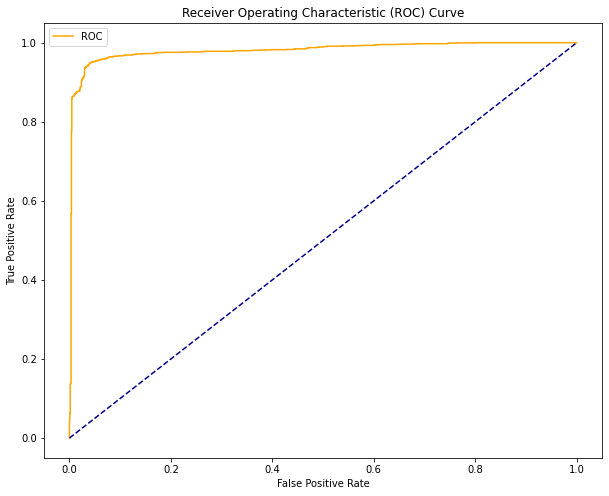

AUC: 0.9806521008403363


In [29]:
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metr.roc_curve(Y_test, preds)
roc_auc = metr.auc(fpr, tpr)

plot_roc_curve(fpr, tpr,roc_auc)

## Neural Network

**Neural Network Model**

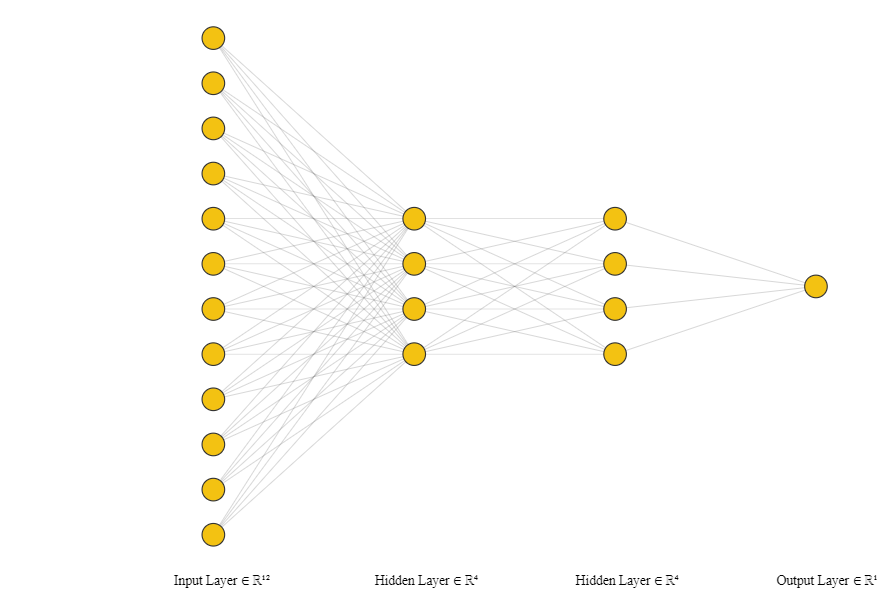

In [30]:
neural_df = clients_sample

X_train, X_test, Y_train, Y_test = train_test_split(neural_df.drop(['Churn_ID'], axis = 1), 
                                                    neural_df.Churn_ID, 
                                                    test_size=0.4)

In [31]:
#create model
neural_model = Sequential()

#First Hidden Layer
neural_model.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=12))

#Second  Hidden Layer
neural_model.add(Dense(4, activation='relu', kernel_initializer='random_normal'))

#Output Layer
neural_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [32]:
#Compiling the neural network
neural_model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
neural_model.fit(X_train,Y_train, batch_size=10, epochs=100)

Epoch 1/100
4800/4800 [==============================] - 1s 221us/step - loss: 0.6605 - accuracy: 0.7400
Epoch 2/100
4800/4800 [==============================] - 1s 132us/step - loss: 0.4770 - accuracy: 0.9510
Epoch 3/100
4800/4800 [==============================] - 1s 131us/step - loss: 0.3367 - accuracy: 0.9527
Epoch 4/100
4800/4800 [==============================] - 1s 127us/step - loss: 0.2732 - accuracy: 0.9521
Epoch 5/100
4800/4800 [==============================] - 1s 133us/step - loss: 0.2374 - accuracy: 0.9515
Epoch 6/100
4800/4800 [==============================] - 1s 136us/step - loss: 0.2145 - accuracy: 0.9517
Epoch 7/100
4800/4800 [==============================] - 1s 145us/step - loss: 0.1993 - accuracy: 0.9513
Epoch 8/100
4800/4800 [==============================] - 1s 144us/step - loss: 0.1890 - accuracy: 0.9513
Epoch 9/100
4800/4800 [==============================] - 1s 143us/step - loss: 0.1819 - accuracy: 0.9521
Epoch 10/100
4800/4800 [==============================]

In [33]:
eval_model=neural_model.evaluate(X_train, Y_train)
print('Loss and accuracy')
eval_model

4800/4800 [==============================] - 0s 21us/step
Loss and accuracy


[0.1507425814246138, 0.9554166793823242]

In [34]:
y_pred=neural_model.predict(X_test)
y_pred =(y_pred>0.5)

In [35]:
print('Score:',accuracy_score(Y_test,y_pred))

print('\n\nConfusion matrix')
print(confusion_matrix(Y_test, y_pred))

print('\n\nClassification report\n')
print(classification_report(Y_test, y_pred))

Score: 0.9521875


Confusion matrix
[[1219   57]
 [  96 1828]]


Classification report

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1276
           1       0.97      0.95      0.96      1924

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



### ROC

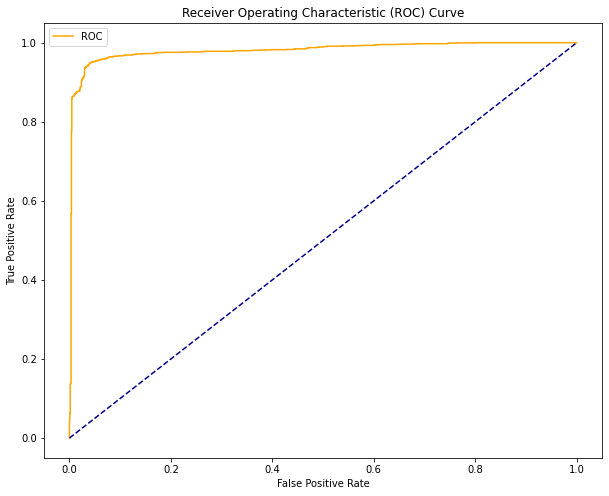

AUC: 0.9774847414933621


In [36]:
y_pred_keras=neural_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

roc_auc = auc(fpr_keras, tpr_keras)

plot_roc_curve(fpr, tpr,roc_auc)

## K-Means

### Determine number of components

To make our K-means model we'll use the PCA method for dimensionality reduction. But first we'll normalize the data using StandardScaler.

In [37]:
X = StandardScaler().fit_transform(clients_churn2.drop(['Churn_ID'], axis = 1))

pca = PCA()
X_pca = pca.fit(X)

pca.explained_variance_ratio_

array([0.16672411, 0.11551695, 0.08169086, 0.07525442, 0.07033081,
       0.04639792, 0.04462055, 0.04362126, 0.04248925, 0.04165052,
       0.04052658, 0.03771982, 0.0355646 , 0.03046192, 0.02862774,
       0.02283824, 0.02124881, 0.01621313, 0.01430619, 0.0096013 ,
       0.00468103, 0.0041273 , 0.00385926, 0.00192741])

Text(0, 0.5, 'Cumulative Explained Variance')

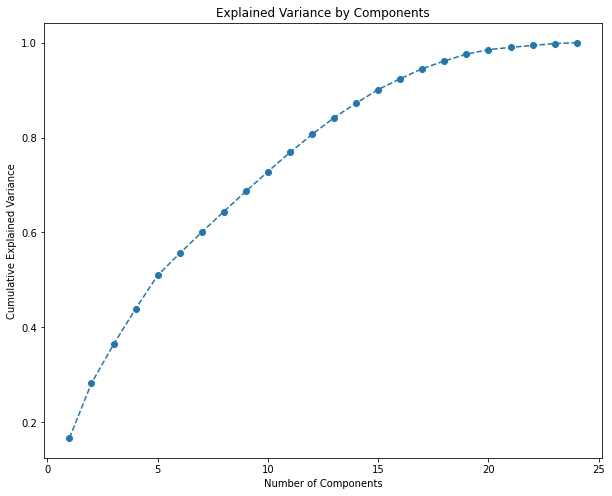

In [38]:
plt.figure(figsize=(10,8))
plt.plot(range(1,25),pca.explained_variance_ratio_.cumsum(),marker = 'o', linestyle='--')

plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

With this graph we can determine that using 12 main components we can explain almost 80% of the variability of the data. So we proceed to use PCA with only 12 main components.

In [39]:
pca = PCA(n_components= 12)
pca.fit(X)
scores_pca = pca.transform(X)
scores_pca

array([[ 4.60183557,  0.13872542, -0.74087353, ...,  0.09061767,
         0.3027158 ,  1.4206124 ],
       [ 2.7311159 , -2.87716756,  1.71137045, ...,  0.13581497,
         0.77007004, -0.41458297],
       [ 5.05709213, -0.27823569,  0.59529861, ..., -0.10153583,
         1.16006009, -0.18765342],
       ...,
       [ 0.17331393, -4.38446128,  3.93805222, ..., -0.17676129,
         1.13604978,  1.45259227],
       [-2.94961354,  0.15345159,  0.34465612, ...,  0.2633255 ,
        -0.02010337,  0.63110163],
       [-1.57765909, -2.52561108,  0.71361061, ...,  0.08699573,
        -0.02808316, -0.95094283]])

### Determine number of clusters

In [40]:
sils = []
clusters = [2,3,5]
for x in clusters:
  group_model = KMeans(n_clusters=x).fit(scores_pca)
  sils.append(silhouette_score(scores_pca,group_model.predict(scores_pca)))

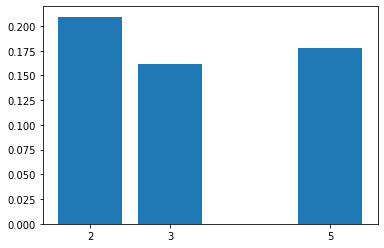

In [41]:
x = clusters
fig, ax = plt.subplots()
plt.bar(x,sils)
plt.xticks(x,x)
plt.show()

To determine the number of clusters, we use silhouette_score as a measure, which is a number that goes from -1 to 1. Being 1 the best value, since it indicates, in summary, that the values within the clusters are grouped correctly. In the bar chart we can determine that the best score is obtained with 2 clusters, therefore we consider that this is the best value for k.

### Train model

In [42]:
clusters = 2
kmeans_pca = KMeans(n_clusters=clusters)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
df_pca_kmeans = pd.DataFrame(scores_pca)
df_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_pca_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,Segment K-means PCA
0,4.601836,0.138725,-0.740874,-0.291527,-2.405130,-1.992942,0.606281,-0.604966,-0.510696,0.090618,0.302716,1.420612,0
1,2.731116,-2.877168,1.711370,0.596939,1.055585,0.431629,1.834313,-0.413710,-0.903109,0.135815,0.770070,-0.414583,0
2,5.057092,-0.278236,0.595299,-0.493106,-1.163573,-2.769544,-0.821892,0.055604,-0.487749,-0.101536,1.160060,-0.187653,0
3,4.219958,0.077475,0.730312,-0.791919,0.193582,-2.747161,-0.377698,1.867519,-1.166103,-0.281439,2.351108,0.698660,0
4,2.498386,2.287953,-1.085499,5.328364,-0.048376,-1.410414,-0.367172,1.122428,-0.919192,-0.012584,1.594545,0.706474,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18125,-2.529881,-0.703685,-0.036809,0.171992,-0.252386,0.307329,0.690956,1.237411,0.084914,-0.209374,0.163323,0.968337,1
18126,-2.327220,-0.889974,0.218949,0.202512,-0.235580,1.022185,-0.090291,-0.922636,0.539238,0.154132,-1.101684,-0.034345,1
18127,0.173314,-4.384461,3.938052,1.071143,0.201048,0.606967,0.390242,1.514988,-0.599926,-0.176761,1.136050,1.452592,1
18128,-2.949614,0.153452,0.344656,-0.228790,-1.055501,1.217283,-0.801436,-0.384695,-0.517640,0.263326,-0.020103,0.631102,1


In [44]:
colors = ['r','c','g','m','y','k']

def train_models():
  for clusters in [2,3,5]:
    kmeans_pca = KMeans(n_clusters=clusters)
    kmeans_pca.fit(scores_pca)

    df_pca_kmeans = pd.DataFrame(scores_pca)
    df_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    groups = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']

    clusters_dic = {}
    for x in range(0,clusters):
      clusters_dic[x] = groups[x]

    df_pca_kmeans['Segment'] = df_pca_kmeans['Segment K-means PCA'].map(clusters_dic)

    dict = {}
    dict[0] = []
    dict[1] = []
    dict['Segment'] = []

    for x in range(0,clusters):
      dict[0].append(kmeans_pca.cluster_centers_[x][0])
      dict[1].append(kmeans_pca.cluster_centers_[x][1])
      dict['Segment'] = 'Centroid'

    df1 = pd.DataFrame(dict)

    df_pca_kmeans = df_pca_kmeans.append(df1)

    x_axis = df_pca_kmeans[1]
    y_axis = df_pca_kmeans[0]

    plt.figure(figsize=(10,8))

    sns.scatterplot(x_axis,y_axis, hue=df_pca_kmeans['Segment'], palette=colors[0:clusters+1])
    plt.title('Clusters by PCA Components')
    plt.show()



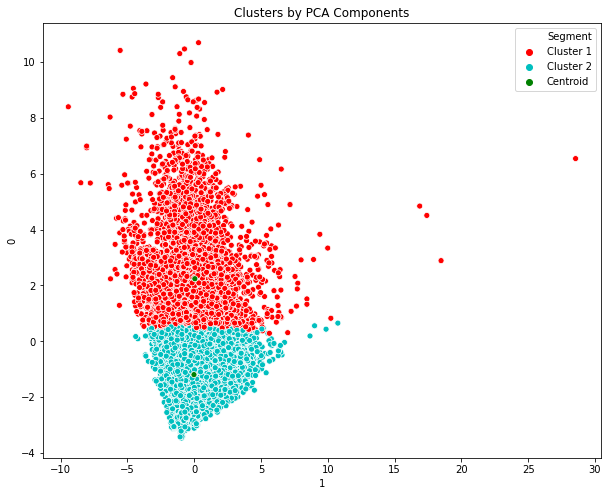

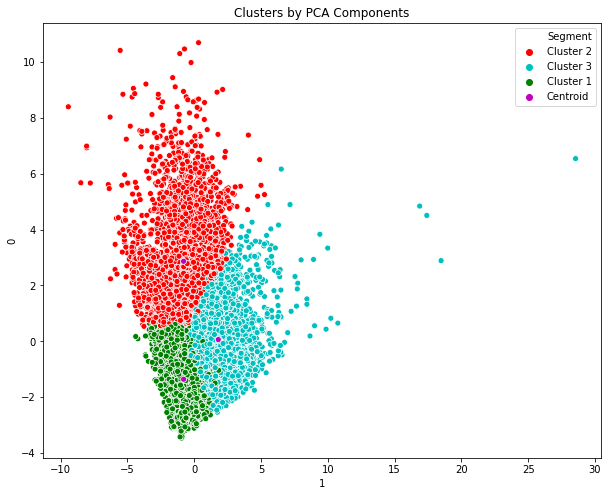

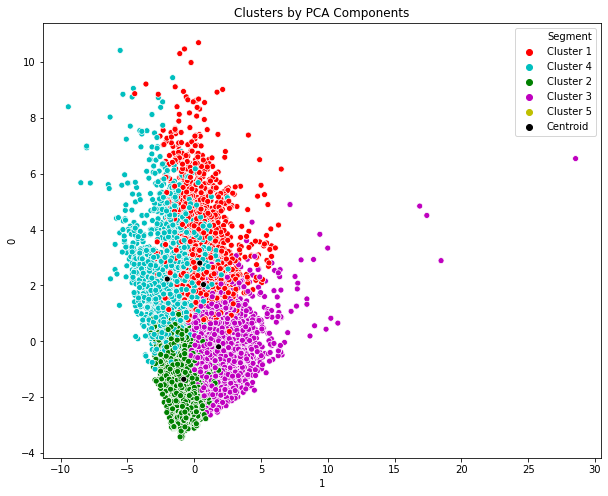

In [45]:
train_models()